# Lab 07: Airline Tweets Sentiment Analysis

---
author: Henry Guo
date: April 15, 2024
embed-resources: true
---

## Introduction

Working at the  intersection of the data and social teams for a major US airline, we build a sentiment classifier that will allow customer service representatives to respond to negative tweets about the airline and for positive tweets to be automatically acknowledged. The goal is for the sentiment classifier to automatically classify tweets at US airlines as one of three sentiments: negative, neutral, or positive. Data comes from [Kaggle](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment). We are using modified data that only contains variables: airline_sentiment, text, and airline. 



## Methods

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, CountVectorizer, TfidfTransformer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from joblib import dump

### Data

In [34]:
tweets = pd.read_csv("https://cs307.org/lab-07/data/tweets.csv")
tweets_train, tweets_test = train_test_split(
    tweets,
    test_size=0.25,
    random_state=42,
)
# create X and y for train data
X_train = tweets_train["text"]
y_train = tweets_train["sentiment"]

# create X and y for test data
X_test = tweets_test["text"]
y_test = tweets_test["sentiment"]

In [35]:
top_100_counter = CountVectorizer(max_features=5000)
X_top_100 = top_100_counter.fit_transform(X_train)
plane_idx = np.where(top_100_counter.get_feature_names_out() == "bad")
plane_count = np.sum(X_top_100.todense()[:, plane_idx])
print('The Word "bad" Appears:', plane_count)

The Word "bad" Appears: 98


In [36]:
# summary statistics
airline_counts = tweets_train["airline"].value_counts()
airline_proportions = tweets_train["airline"].value_counts(normalize=True)

print("Airline Counts:")
print(airline_counts)
print("\nAirline Proportions:")
print(airline_proportions)

Airline Counts:
airline
United            2166
US Airways        1664
American          1551
Southwest         1347
Delta             1239
Virgin America     268
Name: count, dtype: int64

Airline Proportions:
airline
United            0.263024
US Airways        0.202064
American          0.188342
Southwest         0.163570
Delta             0.150455
Virgin America    0.032544
Name: proportion, dtype: float64


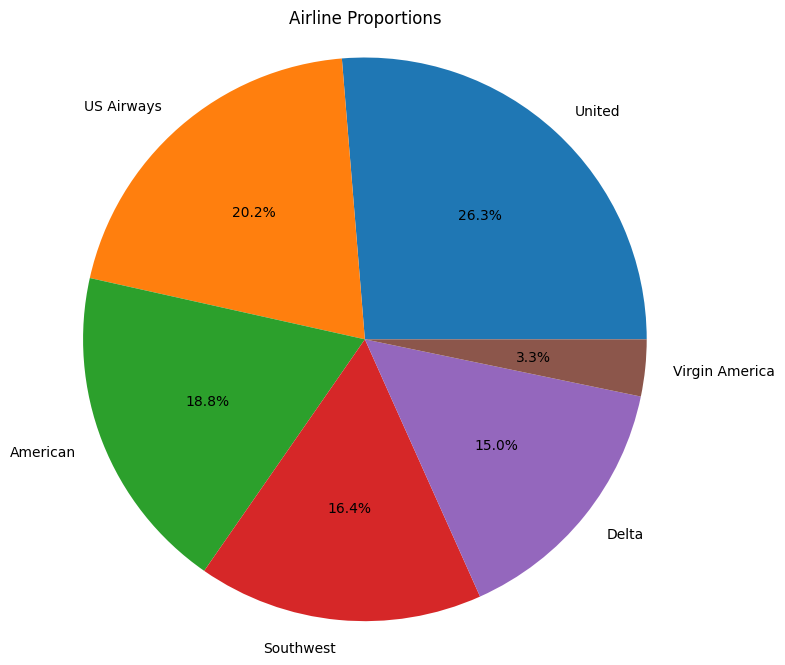

In [37]:
# visualizations
plt.figure(figsize=(8, 8))
plt.pie(airline_proportions, labels=airline_proportions.index, autopct='%1.1f%%')
plt.title("Airline Proportions")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

### Models

In [38]:
# process data for ML
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

# Define the parameter grid for grid search
param_grid = {
    'vect__max_features': [100,140,180,220,260],
    'tfidf__use_idf': [True, False],
    'clf__C': [0.1, 1, 10],
}

# Create a grid search object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)

# Fit the grid search object on the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)


## Results

In [39]:
# Calculate the accuracy on the test data
test_accuracy = accuracy_score(y_test, y_pred)
print(grid_search.best_params_)
print(f"Test Accuracy: {test_accuracy:.2f}")
# Saving Model
dump(grid_search,'airline-sentiment.joblib')

{'clf__C': 10, 'tfidf__use_idf': False, 'vect__max_features': 260}
Test Accuracy: 0.76


['airline-sentiment.joblib']

## Discussion

We vectorized the text into a matrix of token counts, transforms the count matrix into a normalized TF-IDF representation, and classfied it using logistic regression. Sarcasm can certainly contribute negatively against our accuracy,as the model portrays positive words with a negative prediction or vice versa. 

### Conclusion

We only achieved an accuracy of below 80%, which means that we should improve the model instead of using it.